## Deep Q-Learning

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

import gym

## Listing available GYM environments

In [2]:
gym.envs.registry

{'ALE/Adventure-v5': EnvSpec(id='ALE/Adventure-v5', entry_point='ale_py.env.gym:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'game': 'adventure', 'obs_type': 'rgb', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Adventure', version=5),
 'ALE/Adventure-ram-v5': EnvSpec(id='ALE/Adventure-ram-v5', entry_point='ale_py.env.gym:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'game': 'adventure', 'obs_type': 'ram', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Adventure-ram', version=5),
 'ALE/AirRaid-v5': EnvSpec(id='ALE/AirRaid-v5', 

## Loading CartPole env

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [4]:
obs, info = env.reset(seed=42)

In [5]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [6]:
info

{}

In [7]:
img = env.render()

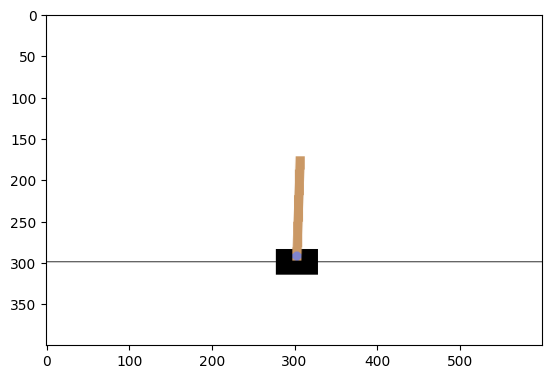

In [8]:
plt.imshow(img)

## Discrete actions are integers up to 2, so 0, 1 here

In [9]:
env.action_space

Discrete(2)

## 0: accelerate left
## 1: accelerate right

In [10]:
action = 1

In [ ]:
obs, reward, done, truncated, info = env.step(action)

In [12]:
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

In [13]:
reward

1.0

In [14]:
done

False

## Truncation can happen by e.g. env wrapper ending episode before normal termination

In [15]:
truncated

False

In [16]:
info

{}

## One should call env.close() upon finishing working with env to free resources

# Deep Q-Learning

## Tabular Q-learning does not scale, even for simple PacMan game there are way more than 10^45 states
## One must use function approximation for Q_value

## For DQN one must formulate proper leaning target: this comes from Bellman optimality target

## max in Q reflects the greedy policy playing optimally from $s', a'$ onwards

## In this way we achieve two things simultaneously: 
* ### We accumulate rewards refining Q-value estimates
* ### We correct Q_value function approximator towards these estimates each at each passing

$$ y(s, a) = r + \gamma\ \underset{a'}{max}\ Q_{\theta}(s', a') $$

## Normally the Q value approximator takes (s, a) as input pair, but more efficient way takes just (s) as input and predicts values for all actions (a). In this way only one inference is needed instead of #{A} inferences

In [17]:
input_shape = [4] # ==env.observation_space.shape
n_outputs = 2 # == env.action.space.n

## The models

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    tf.keras.layers.Dense(32, activation='elu') ,
    tf.keras.layers.Dense(n_outputs)
    ])

## $\epsilon$-greedy policy

In [21]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.choice(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax() # Optimal action according to DQN

## Replay buffer
### An essential part of RL system is replay buffer storing old experiences. Random sampling from it prevents high correlations within a training batch and helps training.

In [24]:
# Two ended queue replay buffer
from collections import deque

In [25]:
replay_buffer = deque(maxlen=2000)

## Experience will follow SARSA format with additional Done and Truncated boolean variables

## Function sampling from the buffer

In [31]:
def sample_experiences(batch_size):
    # Random sampling
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    # Random access to deque can be slow for large buffers, one can use
    # circular buffer or Reverb library from DeepMind
    batch = [replay_buffer[index] for index in indices]
    # Forming 6 arrays containing separate SARSADT variables
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ] # [states, actions, rewards, next_states, dones, truncateds]

## Function playing one step with $\epsilon$-greedy policy and storing experience in the replay buffer

In [29]:
def play_one_step(env, state, epsilon):
    # Action selection
    action = epsilon_greedy_policy(state, epsilon)
    # Environment step with the selected action
    next_state, reward, done, truncated, info = env.step(action)
    # Storing experience tuple in SARSADT format
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

## Hyperparameters

In [30]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

## Training Step

In [36]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    # Unpacking individual SARSADT arrays
    states, actions, rewards, next_states, dones, truncateds = experiences
    # Forming target for DQN training
    # First computing bootstrapped future retruns extimate
    next_Q_values = model.predict(next_states, verbose=0)
    # Choosing greedy actions values (Belman optimality condition)
    # This creates batch_sized array values for 0 xor 1 actions
    max_next_Q_values = next_Q_values.max(axis=1)
    # Episode termination condition: checking for done or truncated state
    runs = 1.0 - (dones | truncateds)
    # Q-value target
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    # Forming model prediction to be compared with the target computed above
    # Masking action value predictions of actions that were not experienced
    # i.e. not present in the replay buffer
    mask = tf.one_hot(actions, n_outputs)
    # Computing prediciton with gradients tracking
    with tf.GradientTape() as tape:
        # model prediciton with values for all actions possible in input states,
        # to be masked out to match what was actually chosen and stored in replay 
        # buffer during environment play one step call
        all_Q_values = model(states)
        # Q_values predictions for the recorded experiences
        # masking does similar thing what .max() gave above
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
        

## Model training

In [ ]:
for episode in tqdm(range(600)):
    # Environment reset at episod start
    # This sets the initial state S of SARSA
    obs, info = env.reset()
    for step in range(200):
        # epsilon-greedy policy decay
        epsilon = max(1 - episode / 500, 0.01)
        # Here we input the initial state S of episode reset and
        # follow states progression onwards
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # DQN training starts after first 50 episodes
    if episode > 50:
        training_step(batch_size)

## DQN is quite unstable: *catastrophic forgetting* plagues it as data distribution is not stationary

## Loss in DQN can go up while rewards are also higher: DQN can start properly assigning higher values to underestimated transitions leading to a better policy, but since the same network sets training target by predictions higher target values lead to higer losses initially

## Some RL issues mitigation approaches:

### Fixed Q-value targets: use a frozen copy of the network to set targets and update it every e.g. 10.000 steps

In [ ]:
# Clone model
target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
# In training_step(): replace
next_Q_vales = target.predict(next_states, verbose=0)

In [ ]:
# In te trainig loop update the frozen net every N steps, e.g.
if episode % 50 == 0:
    target.set_weights(model.get_weights())

## Double DQN

### max in Q-learning leads to Q-value overestimation in function approximation case so one can use two networks and use online network to select actions and target network to provide Q-value estimates for training

In [ ]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    # Unpacking individual SARSADT arrays
    states, actions, rewards, next_states, dones, truncateds = experiences
    # Forming target for DQN training
    # First computing bootstrapped future retruns extimate
    next_Q_values = model.predict(next_states, verbose=0)

    # Choosing greedy action with the online model
    best_next_actions = next_Q_values.argmax(axis=1)

    # Now we want to compute the max next Q values for the target
    # with the target network, but with actions selected by the online 
    # network
    # We mask out Q-value predictions of actions, which are not greedy best
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask).sum(axis=1)

    # The rest stays the same
    
    # Episode termination condition: checking for done or truncated state
    runs = 1.0 - (dones | truncateds)
    # Q-value target
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    # Forming model prediction to be compared with the target computed above
    # Masking action value predictions of actions that were not experienced
    # i.e. not present in the replay buffer
    mask = tf.one_hot(actions, n_outputs)
    # Computing prediciton with gradients tracking
    with tf.GradientTape() as tape:
        # model prediciton with values for all actions possible in input states,
        # to be masked out to match what was actually chosen and stored in replay 
        # buffer during environment play one step call
        all_Q_values = model(states)
        # Q_values predictions for the recorded experiences
        # masking does similar thing what .max() gave above
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

## Prioritized Experience Replay

### Sampling of the replay buffer was uniform but one could sample it based on importance dictated by e.g. TD error


$$ \delta = r + \gamma V(s') - V(s) $$

### Large TD error indicates surprising sample and is worths learning
### Samples are assigned sampling probability $p=|\delta|^\zeta$ when storing in the buffer and this sets resampling probability (initially p is larger to ensure higher probability of using new unseen experiences in training)

### This biases the dataset and requires weighting down contributions of such samples during trainig, like .e.g. $w=(n P)^{-\beta}$ where $n$ is the number of such samples in the buffer

## Dueling DQN

### Q-value of (s, a) pair can be written as

$$ Q(s, a) = V(s) + A(s, a) $$

### with A being the advantage of selecting action $a$ in state $s$ above other actions.

### Under greedy policy value of a state is actually $Q(s, a*)$ where $a*$ is argmax of $Q$, the greedy optimal action

### In this situation $A(s, a*) == 0$

### Dueling DQN uses two-paths network which internally outputs separately $V$ and $A$ estimators, which are then combined to form one output Q-value estimate. 

### Such a model can be directly injected into the previous DQNs and combibed with other enhancements above

In [ ]:
input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation='elu')(input_states)
hidden2 = tf.keras.layers.Dense(32, activation='elu')(hidden1)

# V(s)
state_values = tf.keras.layers.Dense(1)(hidden2)

# A(s, a)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)

advantages = raw_values - tf.reduce_max(raw_advantages, axis=1, keepdims=True)

Q_values = state_values + advantages

model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

## All these techniques can be combined, use of six such enhancements led to the SOTA rainbow model